In [41]:
import numpy as np
from matplotlib.animation import FuncAnimation  
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [42]:
import pickle

# Replace 'filename.pkl' with the path to your actual pickle file
# with open('/home/edu/embeddings/all_manifest_embeddings.pkl', 'rb') as file:
with open('/home/edu/embeddings/PCCh23_30_embeddings.pkl', 'rb') as file:
    data = pickle.load(file)  # `data` is a dict



In [43]:
print(f'Length of `data` (number of samples) = {len(data.keys())}')

Length of `data` (number of samples) = 5238


Embeddings in `data` are indexed by `'folder@label@filename'`.

The dictionary `embeddings` will to store the representations grouped by label

In [44]:
import numpy as np
# Store embeddings grouped by label
embeddings_by_label = {}
embeddings = []
labels = []
# Iterate over the dictionary items
for key, value in data.items():
    # Parse the key to extract the label
    _, label, _ = key.split('@')

    # If the label is not in the dictionary, add it with an empty list
    if label not in embeddings_by_label:
        embeddings_by_label[label] = []

    # Append the embedding to the correct label list
    embeddings_by_label[label].append(value)

    labels.append(label)
    embeddings.append(value)


embeddings = np.array(embeddings)

In [45]:
unique_labels = list(set(labels))
unique_labels.sort()
K = 10  # Min samples per label
valid_labels = [label for label in unique_labels if len(embeddings_by_label[label]) >= K]

print(f'Number of total labels = {len(unique_labels)}')
print(f'Number of valid labels) = {len(valid_labels)}')



Number of total labels = 122
Number of valid labels) = 93


In [46]:
for label in set(unique_labels) - set(valid_labels):  # Labels to remove
    embeddings_by_label.pop(label, None)

embeddings = []
labels = []

# Iterate over the dictionary items
for key, value in embeddings_by_label.items():
    i = valid_labels.index(key)
    labels.extend([i] * len(value))
    embeddings.extend(value)

labels = np.array(labels)
embeddings = np.array(embeddings)

In [47]:
embeddings.shape, labels.shape

((5108, 192), (5108,))

We calculate the centroid of each label and store it in `centroids`

In [48]:
centroids_by_label = {}

# Calculate centroid for each label
for label, emb_list in embeddings_by_label.items():
    # Convert list of arrays into a single numpy array
    emb_array = np.array(emb_list)
    # Calculate the mean along axis 0 (mean of each column)
    centroid = np.mean(emb_array, axis=0)
    centroids_by_label[label] = centroid

In [49]:
def cosine_similarity(vec1, vec2):
    """
    Compute the cosine similarity between two vectors.
    Since embeddings are already normalized, we can use the dot product as the cosine similarity.
    """
    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    cosine_similarity = dot_product / (norm_vec1 * norm_vec2)
    return (cosine_similarity + 1) / 2  # Normalized cosine similarity

def arccos(x):
    """
    Compute the arccosine of a value in radians.
    """
    cos_theta = 2*x - 1  # De-normalize cosine similarity
    theta = np.arccos(cos_theta)
    return np.degrees(theta)  # Convert radians to degrees

We calculate the cosine similarity between each sample `i` and each centroid `j` and store it in `similarity_matrix`

In [50]:
# List of centroids
centroids = list(centroids_by_label.values())
centroid_labels = list(centroids_by_label.keys())

# Create an empty matrix to store cosine similarities
similarity_matrix = np.zeros((len(embeddings), len(centroids)))

# Compute cosine similarity for each embedding against each centroid
for i, embedding in enumerate(embeddings):
    for j, centroid in enumerate(centroids):
        similarity_matrix[i, j] = cosine_similarity(embedding, centroid)

In [51]:
# Assuming `centroids` and `embeddings_by_label` are already defined
mean_cosine_similarities = {}

# Iterate over each label for embeddings
for label_i, embs in embeddings_by_label.items():
    mean_cosine_similarities[label_i] = {}
    # Convert embeddings list to an array for efficiency in computation
    embeddings_array = np.array(embs)
    
    # Iterate over each centroid
    for label_j, centroid in centroids_by_label.items():
        # Compute cosine similarity between each embedding and the centroid
        similarities = [cosine_similarity(embedding, centroid) for embedding in embeddings_array]
        # Calculate the mean of these similarities
        mean_cosine_similarities[label_i][label_j] = np.mean(similarities)

# `mean_cosine_similarities` is a dictionary where keys are label_i and values are dictionaries
# with keys as label_j and values as the mean cosine similarity from embeddings of label_i to centroid of label_j

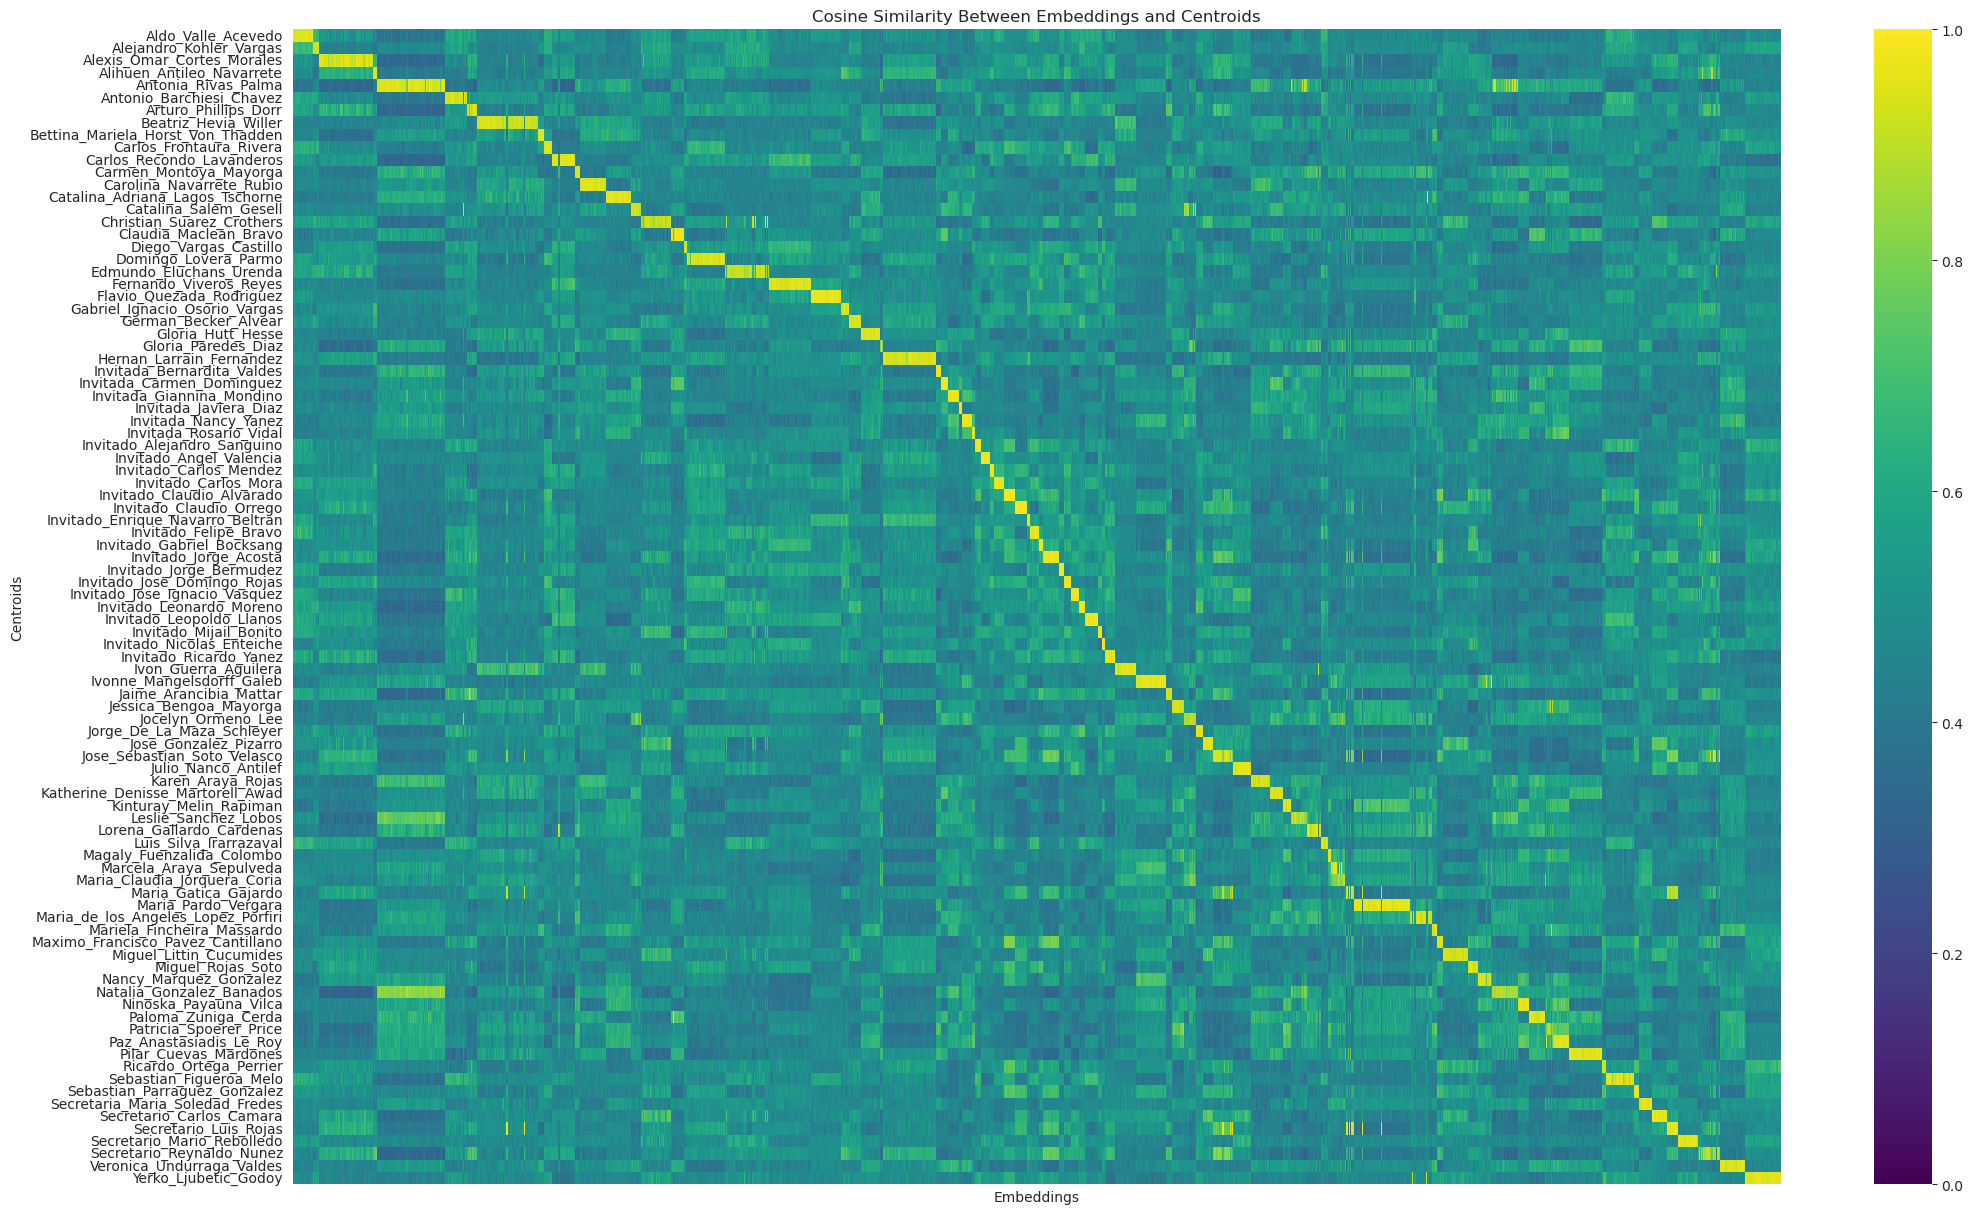

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(24, 15))  # Adjust the size to handle the large matrix
# ax = sns.heatmap(similarity_matrix > .7, cmap='viridis', xticklabels=unique_labels, yticklabels=False)
ax = sns.heatmap(similarity_matrix.T, cmap='viridis',
                 vmin=0, vmax=1, xticklabels=False, 
                 yticklabels=valid_labels
                 )
ax.set_title('Cosine Similarity Between Embeddings and Centroids',
             #fontsize=40
             )
ax.set_xlabel('Embeddings', 
              #fontsize=30
              )
ax.set_ylabel('Centroids',
              #fontsize=30
              )
plt.show()

In [53]:
def shuffle_embeddings(embeddings: np.ndarray, labels: np.ndarray, i: int,
                       num_shuffles: int = 100, embeddings_per_shuffle: int = 50) -> np.ndarray:
    """
    Pseudo-randomly shuffles embeddings for a given label.
    """
    indices = np.where(labels == i)
    subject_embs = embeddings[indices]
    base_seed = hash(label) & 0xffffffff  # Use `& 0xffffffff` for a 32-bit integer
    shuffled_embeddings = np.empty((num_shuffles, embeddings_per_shuffle, subject_embs.shape[1]), 
                                   dtype=subject_embs.dtype)

    for i in range(num_shuffles):
        seed = base_seed + i
        np.random.seed(seed)
        permuted_indices = np.random.permutation(subject_embs.shape[0])[:embeddings_per_shuffle]
        shuffled_embeddings[i] = subject_embs[permuted_indices]

    return shuffled_embeddings

def centroid_evolution(embeddings: np.ndarray, labels: np.ndarray, label: str):
    """
    Characterizes the centroid drift for a given label.
    The centroid drift is calculated as the cosine similarity between the centroid of the first n embeddings
    and the centroid of the first n+1 embeddings.
    We use 100 sequences of the embeddings reordenated randomly to avoid any bias.
    """
    shuffled_embeddings = shuffle_embeddings(embeddings, labels, label, num_shuffles=100, embeddings_per_shuffle=K)
    centroids = np.empty(shuffled_embeddings.shape, dtype=shuffled_embeddings.dtype)

    for i in range(shuffled_embeddings.shape[0]):
        embeddings_sequence = shuffled_embeddings[i]
        for j in range(embeddings_sequence.shape[0]):
            embeddings = embeddings_sequence[:j+1]
            cen = np.mean(embeddings, axis=0)
            centroids[i, j] = cen
        
    similarities = np.empty((shuffled_embeddings.shape[0], shuffled_embeddings.shape[1] - 1, 1))
    for i in range(similarities.shape[0]):
        for j in range(similarities.shape[1]):
            cen1 = centroids[i, j]
            cen2 = centroids[i, j+1]
            sim = cosine_similarity(cen1, cen2)
            similarities[i, j] = sim

    return centroids, similarities

In [54]:
import seaborn as sns

sns.set_style('whitegrid')
import pandas as pd
sims_df = {}
centroids = np.empty((len(valid_labels), K, embeddings.shape[1]), dtype=embeddings.dtype)

for i in range(len(valid_labels)):
    centroid_sequence, similarities = centroid_evolution(embeddings, labels, i)
    sims_df[f'{valid_labels[i]}_mean'] = np.mean(similarities, axis=0).flatten()
    sims_df[f'{valid_labels[i]}_std'] = np.std(similarities, axis=0).flatten()
    avg_centroid_sequence = np.mean(centroid_sequence, axis=0)
    # avg_last_centroid = np.mean(centroid_sequence[:, -1], axis=0)
    centroids[i] = avg_centroid_sequence

sims_df = pd.DataFrame(sims_df)

sims_df.head()


,Aldo_Valle_Acevedo_mean,Aldo_Valle_Acevedo_std,Alejandro_Kohler_Vargas_mean,Alejandro_Kohler_Vargas_std,Alexis_Omar_Cortes_Morales_mean,Alexis_Omar_Cortes_Morales_std,Alihuen_Antileo_Navarrete_mean,Alihuen_Antileo_Navarrete_std,Antonia_Rivas_Palma_mean,Antonia_Rivas_Palma_std,...,Secretario_Luis_Rojas_mean,Secretario_Luis_Rojas_std,Secretario_Mario_Rebolledo_mean,Secretario_Mario_Rebolledo_std,Secretario_Reynaldo_Nunez_mean,Secretario_Reynaldo_Nunez_std,Veronica_Undurraga_Valdes_mean,Veronica_Undurraga_Valdes_std,Yerko_Ljubetic_Godoy_mean,Yerko_Ljubetic_Godoy_std
0,0.971895,0.009915,0.969038,0.016627,0.969475,0.013759,0.958463,0.024192,0.970767,0.017203,...,0.972997,0.036869,0.977677,0.006208,0.912823,0.042884,0.973038,0.010877,0.976757,0.007909
1,0.990435,0.003195,0.987063,0.006130,0.988781,0.004724,0.984240,0.008045,0.988794,0.005976,...,0.990971,0.009168,0.992074,0.002693,0.963343,0.019994,0.990160,0.003643,0.991419,0.002988
2,0.994988,0.001622,0.993737,0.002870,0.993974,0.002398,0.991976,0.003756,0.994330,0.002629,...,0.995444,0.005037,0.995805,0.001350,0.978515,0.010314,0.994987,0.001845,0.995633,0.001453
3,0.996823,0.000943,0.996166,0.001690,0.996502,0.001386,0.995389,0.002277,0.996624,0.001750,...,0.997219,0.003157,0.997574,0.000763,0.987782,0.006596,0.996996,0.001124,0.997575,0.000764
4,0.997893,0.000606,0.997648,0.001078,0.997558,0.001034,0.996849,0.001552,0.997857,0.001257,...,0.998434,0.001156,0.998416,0.000544,0.990536,0.004255,0.998048,0.000674,0.998179,0.000492


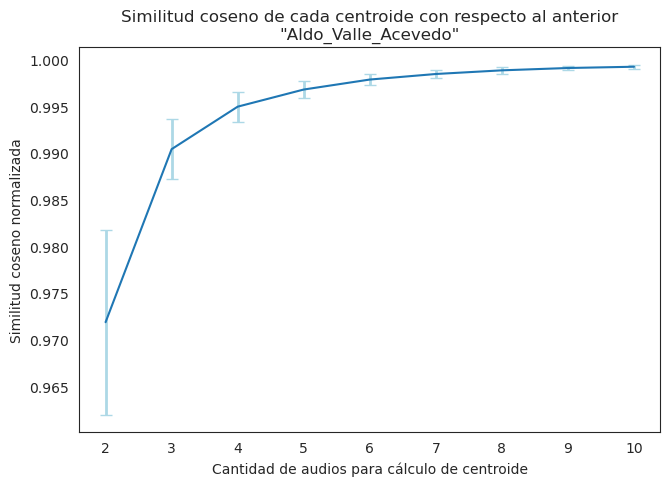

In [81]:
idx = np.arange(2, len(sims_df) + 2)

label = 'Aldo_Valle_Acevedo'
plt.figure(figsize=(7.5, 5))
plt.errorbar(idx[:10], sims_df[f'{label}_mean'][:10], yerr=sims_df[f'{label}_std'][:10], 
            label='Similitud Coseno Normalizada', fmt='-', ecolor='lightblue', elinewidth=2, capsize=4)
plt.xlabel('Cantidad de audios para cálculo de centroide')
plt.ylabel('Similitud coseno normalizada')
plt.title(f'Similitud coseno de cada centroide con respecto al anterior\n"{label}"')
plt.show()
# for label in valid_labels:
#     plt.figure(figsize=(7.5, 5))
#     plt.errorbar(idx[:10], sims_df[f'{label}_mean'][:10], yerr=sims_df[f'{label}_std'][:10], 
#              label='Similitud Coseno Normalizada', fmt='-', ecolor='lightblue', elinewidth=2, capsize=4)
#     plt.xlabel('Cantidad de audios')
#     plt.ylabel('Similitud coseno normalizada')
#     plt.title(f'Similitud coseno entre centroides con respecto al anterior\n"{label}"')

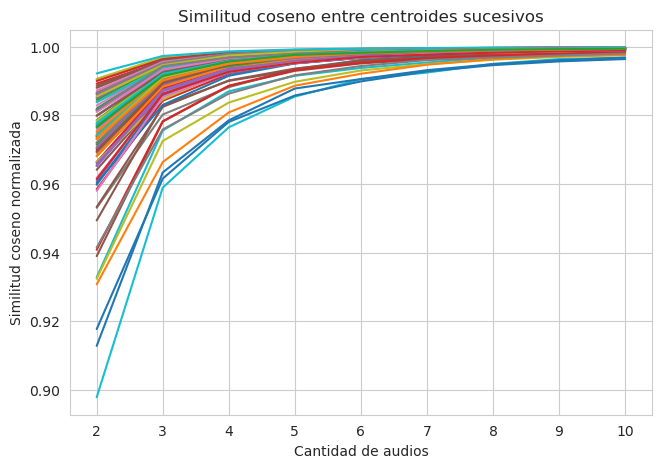

In [56]:
plt.figure(figsize=(7.5, 5))
for label in valid_labels:
    plt.plot(idx[:16], sims_df[f'{label}_mean'][:16])
    plt.xlabel('Cantidad de audios')
    plt.ylabel('Similitud coseno normalizada')
    plt.title(f'Similitud coseno entre centroides sucesivos')

In [57]:
male = [
 'Alejandro_Kohler_Vargas',
 'Alihuen_Antileo_Navarrete',
 'Carlos_Frontaura_Rivera',
 'Diego_Vargas_Castillo',
 'Domingo_Lovera_Parmo',
 'Fernando_Viveros_Reyes',
 'Hector_Urban_Astete',
 'Invitado_Carlos_Mora',
 'Invitado_Claudio_Alvarado',
 'Invitado_Claudio_Orrego',
 'Invitado_Enrique_Navarro_Beltran',
 'Invitado_Gabriel_Bocksang',
 'Invitado_Gonzalo_Garcia',
 'Invitado_Javier_Coussot_Salas',
 'Invitado_Jose_Montt',
 'Invitado_Juan_Ignacio_Gonzalez',
 'Invitado_Leonardo_Moreno',
 'Invitado_Mijail_Bonito',
 'Invitado_Nicolas_Enteiche',
 'Invitado_Pablo_Aranda',
 'Jaime_Arancibia_Mattar',
 'Jorge_Ossandon_Spoerer',
 'Luis_Silva_Irarrazaval',
 'Maximo_Francisco_Pavez_Cantillano',
 'Miguel_Littin_Cucumides',
 'Miguel_Rojas_Soto',
 'Sebastian_Figueroa_Melo',
 'Secretario_Reynaldo_Nunez',
 'Yerko_Ljubetic_Godoy']

female = [
 'Antonia_Rivas_Palma',
 'Beatriz_Hevia_Willer',
 'Carmen_Montoya_Mayorga',
 'Carolina_Navarrete_Rubio',
 'Catalina_Adriana_Lagos_Tschorne',
 'Invitada_Antonia_Polanco',
 'Invitada_Carmen_Dominguez',
 'Invitada_Cecilia_Jara',
 'Invitada_Giannina_Mondino',
 'Invitada_Javiera_Diaz',
 'Invitada_Josefa_Balmaceda',
 'Invitada_Lidia_Casas',
 'Invitada_Paola_Vega',
 'Invitada_Rosario_Vidal',
 'Ivonne_Mangelsdorff_Galeb',
 'Karen_Araya_Rojas',
 'Katherine_Denisse_Martorell_Awad',
 'Kinturay_Melin_Rapiman',
 'Leslie_Sanchez_Lobos',
 'Lorena_Gallardo_Cardenas',
 'Magaly_Fuenzalida_Colombo',
 'Marcela_Araya_Sepulveda',
 'Marcela_Ines_Peredo_Rojas',
 'Maria_Gatica_Gajardo',
 'Maria_de_los_Angeles_Lopez_Porfiri',
 'Mariela_Fincheira_Massardo',
 'Secretaria_Maria_Soledad_Fredes',
 'Veronica_Undurraga_Valdes']

In [58]:
valid_labels

['Aldo_Valle_Acevedo',
 'Alejandro_Kohler_Vargas',
 'Alexis_Omar_Cortes_Morales',
 'Alihuen_Antileo_Navarrete',
 'Antonia_Rivas_Palma',
 'Antonio_Barchiesi_Chavez',
 'Arturo_Phillips_Dorr',
 'Beatriz_Hevia_Willer',
 'Bettina_Mariela_Horst_Von_Thadden',
 'Carlos_Frontaura_Rivera',
 'Carlos_Recondo_Lavanderos',
 'Carmen_Montoya_Mayorga',
 'Carolina_Navarrete_Rubio',
 'Catalina_Adriana_Lagos_Tschorne',
 'Catalina_Salem_Gesell',
 'Christian_Suarez_Crothers',
 'Claudia_Maclean_Bravo',
 'Diego_Vargas_Castillo',
 'Domingo_Lovera_Parmo',
 'Edmundo_Eluchans_Urenda',
 'Fernando_Viveros_Reyes',
 'Flavio_Quezada_Rodriguez',
 'Gabriel_Ignacio_Osorio_Vargas',
 'German_Becker_Alvear',
 'Gloria_Hutt_Hesse',
 'Gloria_Paredes_Diaz',
 'Hernan_Larrain_Fernandez',
 'Invitada_Bernardita_Valdes',
 'Invitada_Carmen_Dominguez',
 'Invitada_Giannina_Mondino',
 'Invitada_Javiera_Diaz',
 'Invitada_Nancy_Yanez',
 'Invitada_Rosario_Vidal',
 'Invitado_Alejandro_Sanguino',
 'Invitado_Angel_Valencia',
 'Invitado_Carlos

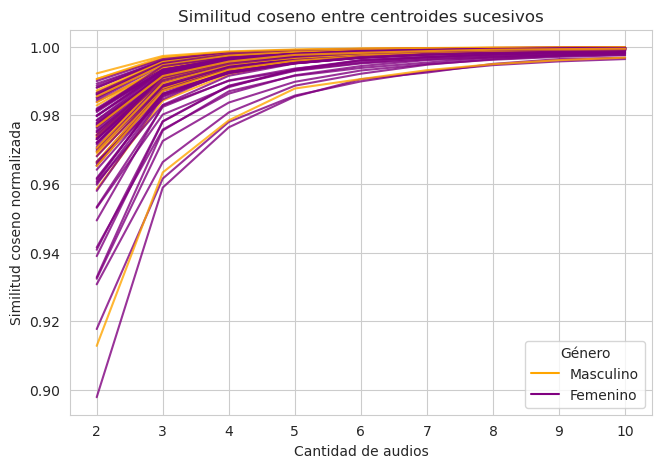

In [59]:
plt.figure(figsize=(7.5, 5))
plt.plot([3], [0.99], label='Masculino', c='orange')
plt.plot([3], [0.99], label='Femenino',c='purple')
for label in valid_labels:
    color = 'orange' if label in male else 'purple'
    plt.plot(idx[:16], sims_df[f'{label}_mean'][:16], color, alpha=0.8)
    plt.xlabel('Cantidad de audios')
    plt.ylabel('Similitud coseno normalizada')
    plt.title(f'Similitud coseno entre centroides sucesivos')
    plt.legend(title='Género', loc='lower right')

In [60]:
centroids.shape

(93, 10, 192)

In [61]:
centroids

array([[[ 0.01039948,  0.02218084, -0.07271469, ..., -0.03867628,
          0.00455077, -0.02465971],
        [ 0.01485762,  0.02105062, -0.07308955, ..., -0.03688475,
          0.00292609, -0.0240335 ],
        [ 0.01592757,  0.01719012, -0.06941722, ..., -0.03928895,
          0.00277017, -0.02407155],
        ...,
        [ 0.01373831,  0.01716162, -0.06999062, ..., -0.03788827,
          0.0014883 , -0.02475034],
        [ 0.01269658,  0.01752551, -0.07019241, ..., -0.03759672,
          0.00122668, -0.02467614],
        [ 0.01276179,  0.01754002, -0.06985619, ..., -0.0378178 ,
          0.00132333, -0.0244658 ]],

       [[ 0.01523115, -0.07687263,  0.08099925, ..., -0.0192417 ,
          0.00683397, -0.05277859],
        [ 0.01791341, -0.07448735,  0.08189873, ..., -0.01714062,
          0.00683319, -0.05283801],
        [ 0.01972243, -0.07278164,  0.08146641, ..., -0.01660534,
          0.00751705, -0.05272112],
        ...,
        [ 0.01969312, -0.0748217 ,  0.08042788, ..., -

In [62]:
N, K, D = centroids.shape  # N speakers, K iterations, D dimensions
interclass_similarities = np.zeros((K, N, N))

for k in range(K):
    centroids_k = centroids[:, k]
    for i in range(N):
        for j in range(N):
            sim = cosine_similarity(centroids_k[i], centroids_k[j])
            interclass_similarities[k, i, j] = sim

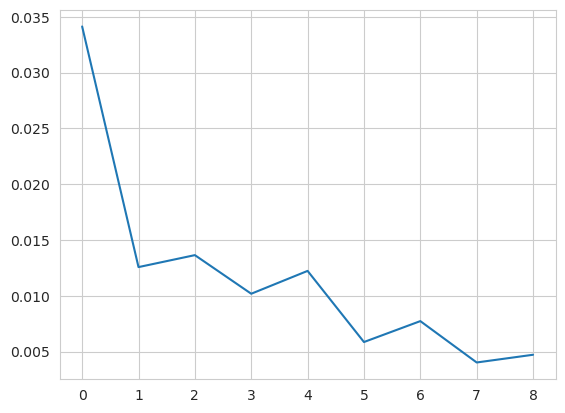

In [63]:
# Calculate the maximum difference between each pair of iterations
M = []
index = []
for k in range(K-1):
    m = np.max(abs(interclass_similarities[k] - interclass_similarities[k+1]))
    M.append(m)
    index.append(k)

plt.plot(index, M)

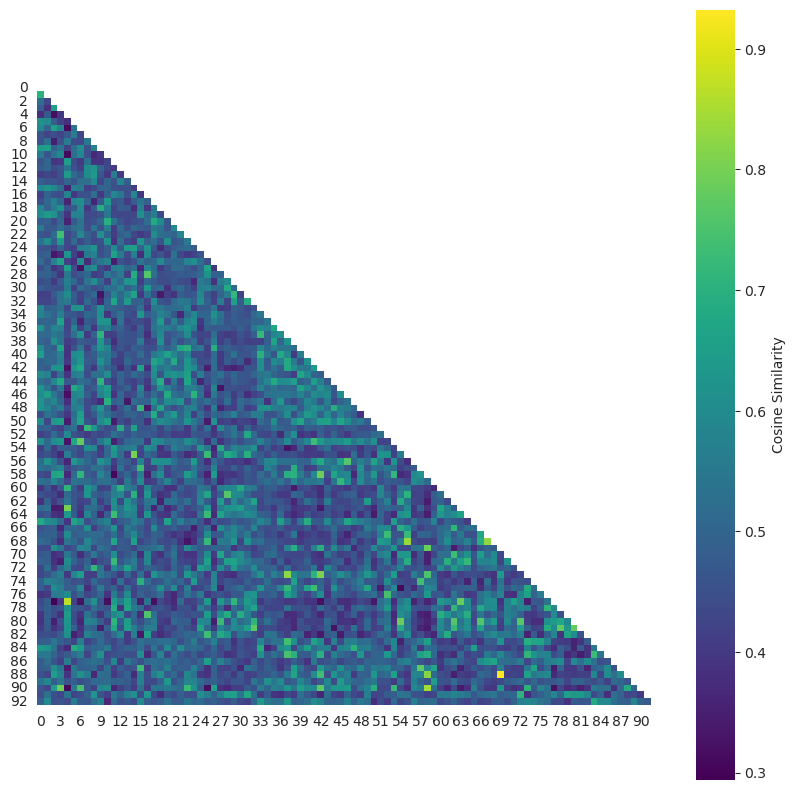

In [64]:
# Create a mask for the upper triangle
m = interclass_similarities[-1]

mask = np.triu(np.ones_like(m, dtype=bool))
plt.figure(figsize=(10, 10))
# Set the upper triangle to NaN
# m[mask] = np.nan
sns.set_style('white')
sns.heatmap(m, cmap="viridis", cbar_kws={'label': 'Cosine Similarity'}, mask=mask, square=True)

plt.show()

In [65]:
interclass_similarities[-1]

array([[1.        , 0.70372364, 0.52333427, ..., 0.45904269, 0.44543109,
        0.48542678],
       [0.70372364, 1.        , 0.42794362, ..., 0.42936039, 0.53349659,
        0.59688769],
       [0.52333427, 0.42794362, 1.        , ..., 0.64364468, 0.45186797,
        0.44486232],
       ...,
       [0.45904269, 0.42936039, 0.64364468, ..., 1.00000006, 0.40058697,
        0.49540425],
       [0.44543109, 0.53349659, 0.45186797, ..., 0.40058697, 1.        ,
        0.46978012],
       [0.48542678, 0.59688769, 0.44486232, ..., 0.49540425, 0.46978012,
        1.        ]])

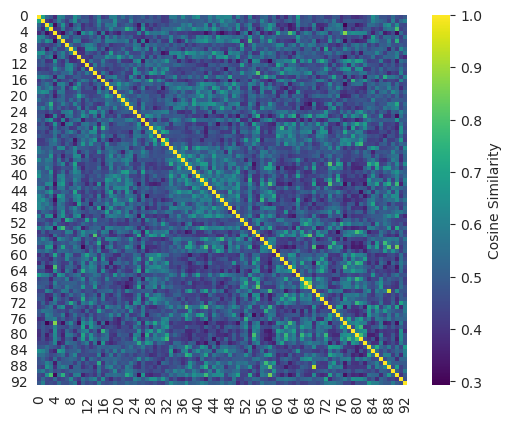

In [66]:
sns.heatmap(interclass_similarities[-1], cmap="viridis", cbar_kws={'label': 'Cosine Similarity'}, square=True)
plt.show()

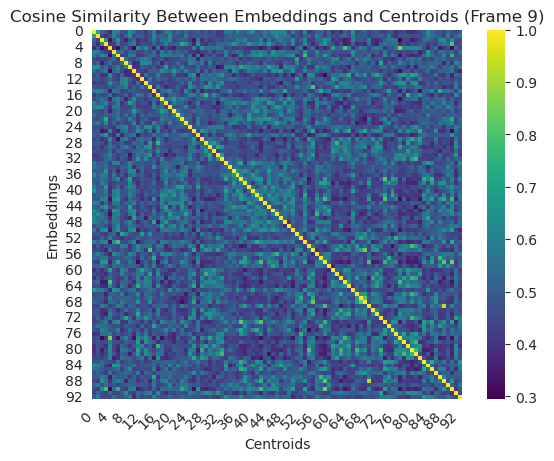

In [67]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Example data: List of 2D arrays representing heatmap data at different time points
# Assuming interclass_similarities is already defined as in your example

# Set up the figure and axis
fig, ax = plt.subplots()

# Create a mask for the upper triangle

# mask = np.triu(np.ones_like(m, dtype=bool))

# Initialize the heatmap
heatmap = sns.heatmap(interclass_similarities[0], cmap='viridis', square=True,
                      # mask=mask,
                      cbar=True, ax=ax)

# Set axis labels and title
ax.set_title('Cosine Similarity Between Embeddings and Centroids')
ax.set_xlabel('Centroids')
ax.set_ylabel('Embeddings')

# Customize tick labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

# Get the QuadMesh object from the heatmap
quadmesh = ax.collections[0]

# Function to update the heatmap
def update(k):
    quadmesh.set_array(interclass_similarities[k].flatten())
    ax.set_title(f'Cosine Similarity Between Embeddings and Centroids (Frame {k})')
    return quadmesh,

# Create the animation
ani = FuncAnimation(fig, update, frames=len(interclass_similarities), blit=False)

# Save the animation or display it
ani.save('heatmap_animation.mp4', writer='ffmpeg', fps=5)
plt.show()

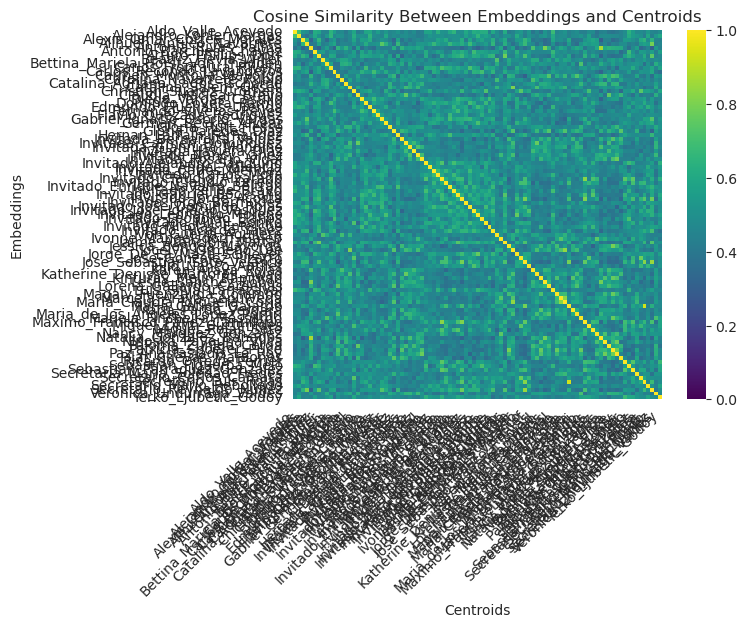

In [68]:
ax = sns.heatmap(interclass_similarities[-1], cmap='viridis', square=True,
                 vmin=0, vmax=1, xticklabels=valid_labels, yticklabels=valid_labels)
ax.set_title('Cosine Similarity Between Embeddings and Centroids')
ax.set_xlabel('Centroids')
ax.set_ylabel('Embeddings')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

In [69]:
centroids.shape
last_centroids = centroids[:, -1]
last_centroids.shape

(93, 192)

In [70]:
last_centroids[0].shape

(192,)

In [71]:
last_centroids = centroids[:, -1]
embedding_own_centroid = []

for n in range(N):
    speaker_embs = embeddings[labels == n]
    cen = last_centroids[n]
    for emb in speaker_embs:
        sim = cosine_similarity(emb, cen)
        embedding_own_centroid.append(sim)

embedding_own_centroid = np.array(embedding_own_centroid)

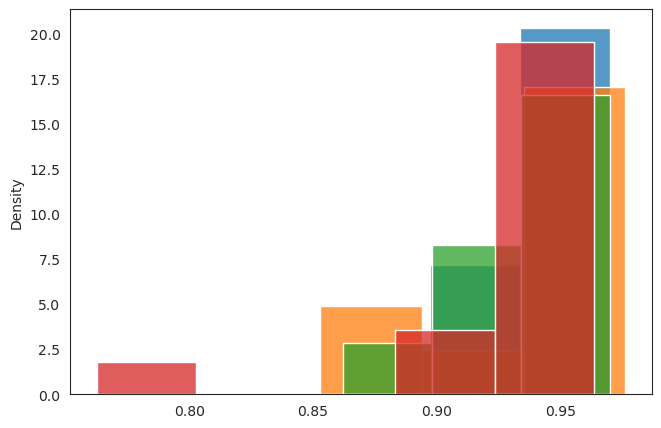

In [72]:
plt.figure(figsize=(7.5, 5))

for n in range(4):
    speaker_embs = embedding_own_centroid[labels == n]
    sns.histplot(speaker_embs, stat='density', binwidth=0.04)


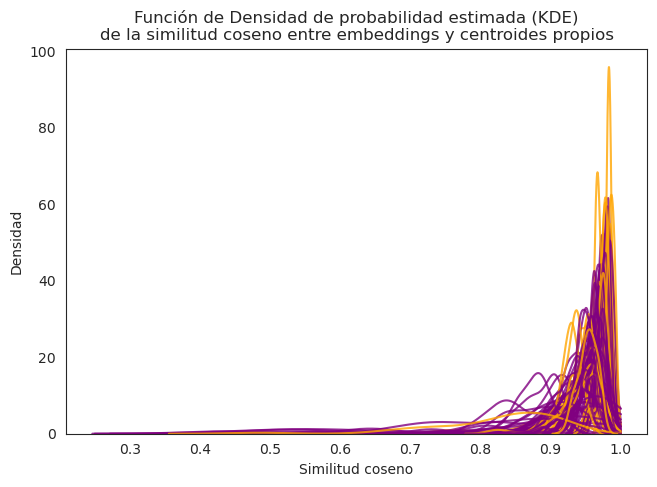

In [73]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(7.5, 5))

# Add a title and labels
plt.title('Función de Densidad de probabilidad estimada (KDE)\nde la similitud coseno entre embeddings y centroides propios')
plt.xlabel('Similitud coseno')
plt.ylabel('Densidad')
domain = (0,1)


for n in range(N):
    speaker = valid_labels[n]
    color = 'orange' if speaker in male else 'purple'
    speaker_embs = embedding_own_centroid[labels == n]
    # Create a KDE plot
    
    sns.kdeplot(speaker_embs, bw_adjust=1, fill=False, clip=domain, color=color, alpha=0.8)
# Show the plot
plt.show()

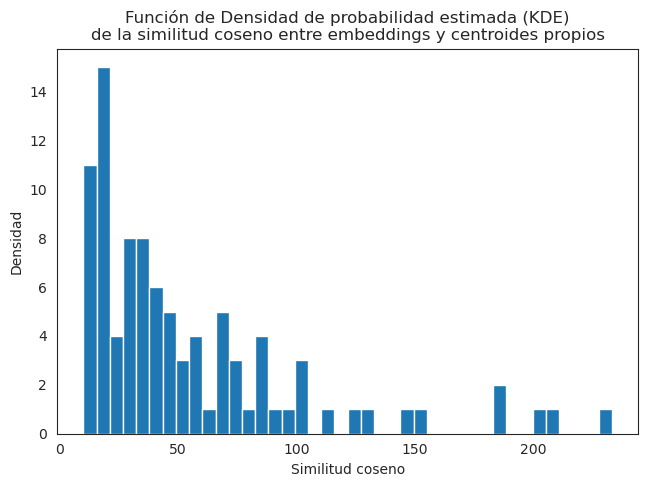

In [74]:
plt.figure(figsize=(7.5, 5))

# Add a title and labels
plt.title('Función de Densidad de probabilidad estimada (KDE)\nde la similitud coseno entre embeddings y centroides propios')
plt.xlabel('Similitud coseno')
plt.ylabel('Densidad')
domain = (0,1)

a = [i for i in range(N)]
counts = [np.sum(labels == n) for n in range(N)]

bins = plt.hist(counts, bins=40)
plt.show()

In [75]:
bins

(array([11., 15.,  4.,  8.,  8.,  6.,  5.,  3.,  4.,  1.,  5.,  3.,  1.,
         4.,  1.,  1.,  3.,  0.,  1.,  0.,  1.,  1.,  0.,  0.,  1.,  1.,
         0.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,
         1.]),
 array([ 10.   ,  15.575,  21.15 ,  26.725,  32.3  ,  37.875,  43.45 ,
         49.025,  54.6  ,  60.175,  65.75 ,  71.325,  76.9  ,  82.475,
         88.05 ,  93.625,  99.2  , 104.775, 110.35 , 115.925, 121.5  ,
        127.075, 132.65 , 138.225, 143.8  , 149.375, 154.95 , 160.525,
        166.1  , 171.675, 177.25 , 182.825, 188.4  , 193.975, 199.55 ,
        205.125, 210.7  , 216.275, 221.85 , 227.425, 233.   ]),
 <BarContainer object of 40 artists>)

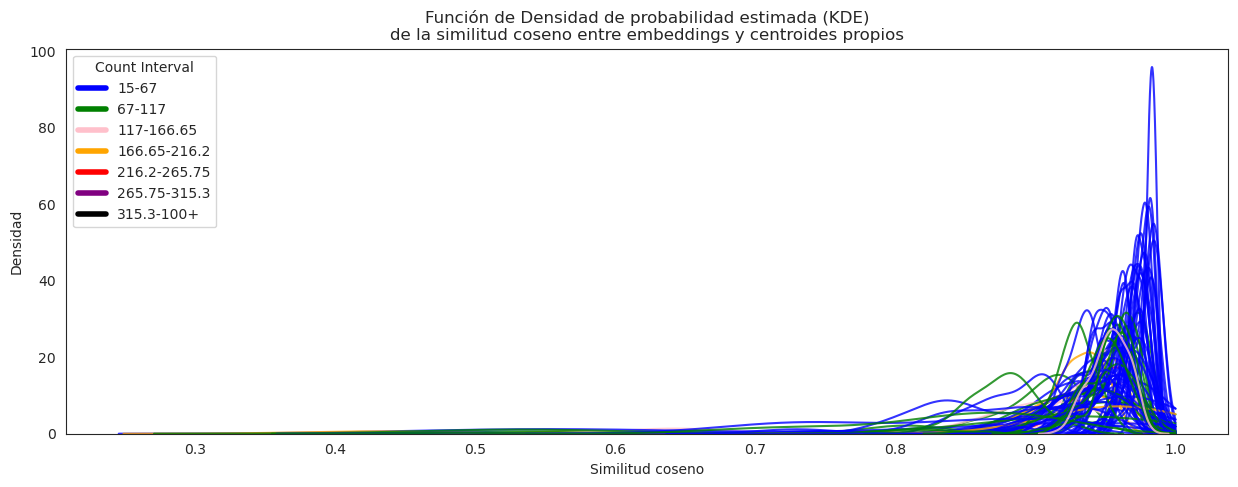

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(15, 5))

# Add a title and labels
plt.title('Función de Densidad de probabilidad estimada (KDE)\nde la similitud coseno entre embeddings y centroides propios')
plt.xlabel('Similitud coseno')
plt.ylabel('Densidad')
domain = (0, 1)

# Define intervals and their corresponding colors
intervals = [
    (15, 67, 'b'),
    (67, 117, 'g'),
    (117, 166.65, 'pink'),
    (166.65, 216.2 , 'orange'),
    (216.2 , 265.75, 'r'),
    (265.75, 315.3 , 'purple'),
    # (60, 70, 'brown'),
    # (70, 80, 'pink'),
    # (80, 90, 'cyan'),
    # (90, 100, 'm'),
    (315.3 , float('inf'), 'k')  # Catch-all for counts >= 100
]

# Plot KDE with colors based on the count interval
for n in range(N):
    speaker = valid_labels[n]
    count = np.sum(labels == n)
    for start, end, color in intervals:
        if start <= count < end:
            speaker_embs = embedding_own_centroid[labels == n]
            sns.kdeplot(speaker_embs, bw_adjust=1, fill=False, clip=domain, color=color, alpha=0.8)
            break

# Create custom legend
handles = [plt.Line2D([0], [0], color=color, lw=4) for _, _, color in intervals]
lbls = [f'{start}-{end if end != float("inf") else "100+"}' for start, end, _ in intervals]
plt.legend(handles, lbls, title='Count Interval')

# Show the plot
plt.show()

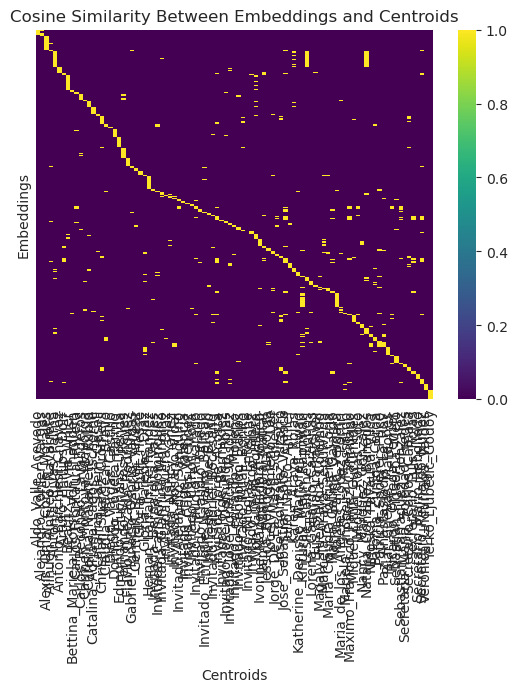

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns

# plt.figure(figsize=(20, 40))  # Adjust the size to handle the large matrix
ax = sns.heatmap(similarity_matrix >.7, cmap='viridis', xticklabels=embeddings_by_label.keys(), yticklabels=False)
ax.set_title('Cosine Similarity Between Embeddings and Centroids')
ax.set_xlabel('Centroids')
ax.set_ylabel('Embeddings')
plt.show()

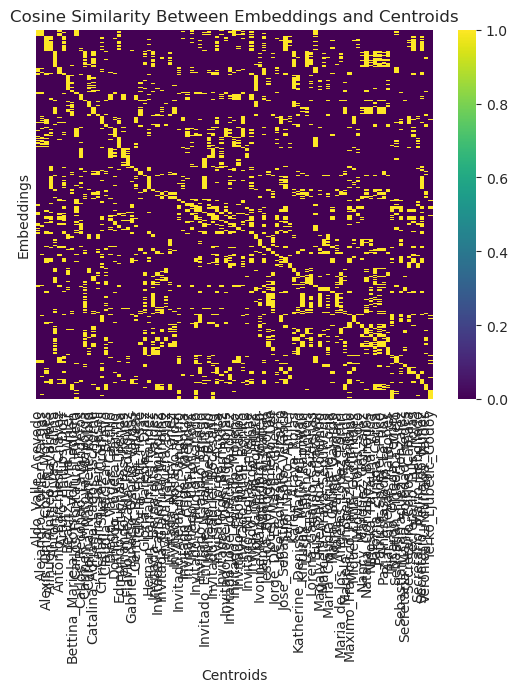

In [78]:
# plt.figure(figsize=(20, 40))  # Adjust the size to handle the large matrix
ax = sns.heatmap(np.abs(similarity_matrix)>.6, cmap='viridis', xticklabels=embeddings_by_label.keys(), yticklabels=False)
ax.set_title('Cosine Similarity Between Embeddings and Centroids')
ax.set_xlabel('Centroids')
ax.set_ylabel('Embeddings')
plt.show()

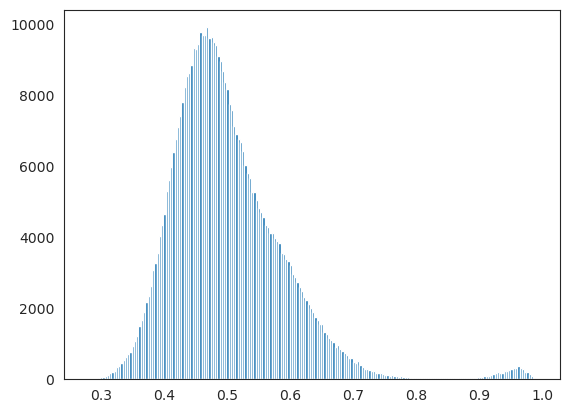

In [79]:
plt.hist((similarity_matrix).reshape(-1), bins=200);
# plt.yscale("log")

In [80]:
a = np.vstack(all_embeddings)

NameError: name 'all_embeddings' is not defined

In [ ]:
a

array([[-0.06897517, -0.05414196,  0.06097658, ..., -0.0272247 ,
         0.06051932, -0.04344228],
       [ 0.0395584 , -0.05582495,  0.04575963, ...,  0.03368031,
        -0.06320056, -0.01052512],
       [ 0.05373601, -0.01926537,  0.058074  , ..., -0.06986475,
        -0.1131865 , -0.0717617 ],
       ...,
       [ 0.0434302 , -0.01863375,  0.11141832, ...,  0.05687591,
        -0.01010055,  0.04494489],
       [ 0.07610386, -0.04430066,  0.05074406, ...,  0.08349352,
        -0.07788533,  0.02240222],
       [ 0.02174916, -0.01224554,  0.07873227, ...,  0.15053266,
        -0.0509986 ,  0.01316411]], dtype=float32)

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=2)
c = pca.fit_transform(np.log(np.abs(a)))

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
b = tsne.fit_transform(a)
a.shape

<ipython-input-69-ddf4dadee454>:3: RuntimeWarning: invalid value encountered in log
  b = tsne.fit_transform(np.log(a))


ValueError: Input X contains NaN.
TSNE does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
!pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 3.0 MB/s eta 0:00:00


In [ ]:
import umap

reducer = umap.UMAP()
u = reducer.fit_transform(a)


AttributeError: module 'umap' has no attribute 'UMAP'

In [ ]:
classes = [[e for _ in range(len(embeddings[e]))] for e in embeddings]
classes_result = []
for i in classes:
  classes_result += i
# Create a color map from unique string labels to colors
unique_classes = list(np.unique(classes_result))
colors = plt.cm.jet(np.linspace(0, 1, len(unique_classes)))  # Generate as many colors as there are unique classes
color_map = dict(zip(unique_classes, colors))

# Map the string labels to colors
class_colors = [color_map[cls] for cls in classes_result]


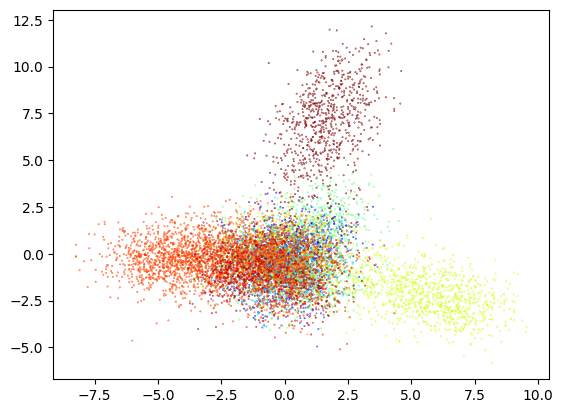

In [ ]:

plt.scatter(*c.T,  color=class_colors, s=.1)

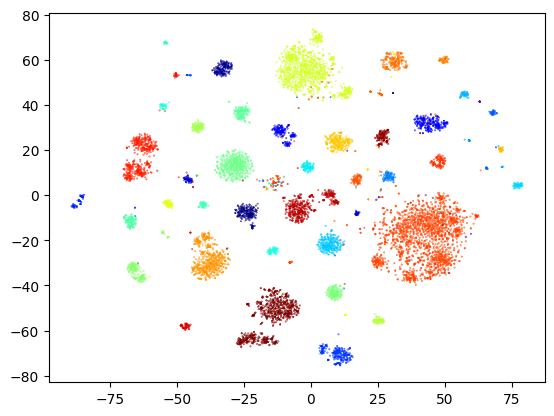

In [ ]:
plt.scatter(*b.T,  color=class_colors, s=.1)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming `similarity_matrix`, `labels`, and `centroid_labels` are already defined

# Create the plot
# plt.figure(figsize=(20, 60))  # Adjust the size to handle the large matrix
ax = sns.heatmap(np.log10(np.abs(similarity_matrix)), cmap='viridis', xticklabels=embeddings.keys(), yticklabels=False)
ax.set_title('Cosine Similarity Between Embeddings and Centroids')
ax.set_xlabel('Centroids')
ax.set_ylabel('Embeddings')
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'keys'

(array([    0., 10000., 20000., 30000., 40000., 50000., 60000., 70000.]),
 [Text(0, 0.0, '0'),
  Text(0, 10000.0, '10000'),
  Text(0, 20000.0, '20000'),
  Text(0, 30000.0, '30000'),
  Text(0, 40000.0, '40000'),
  Text(0, 50000.0, '50000'),
  Text(0, 60000.0, '60000'),
  Text(0, 70000.0, '70000')])

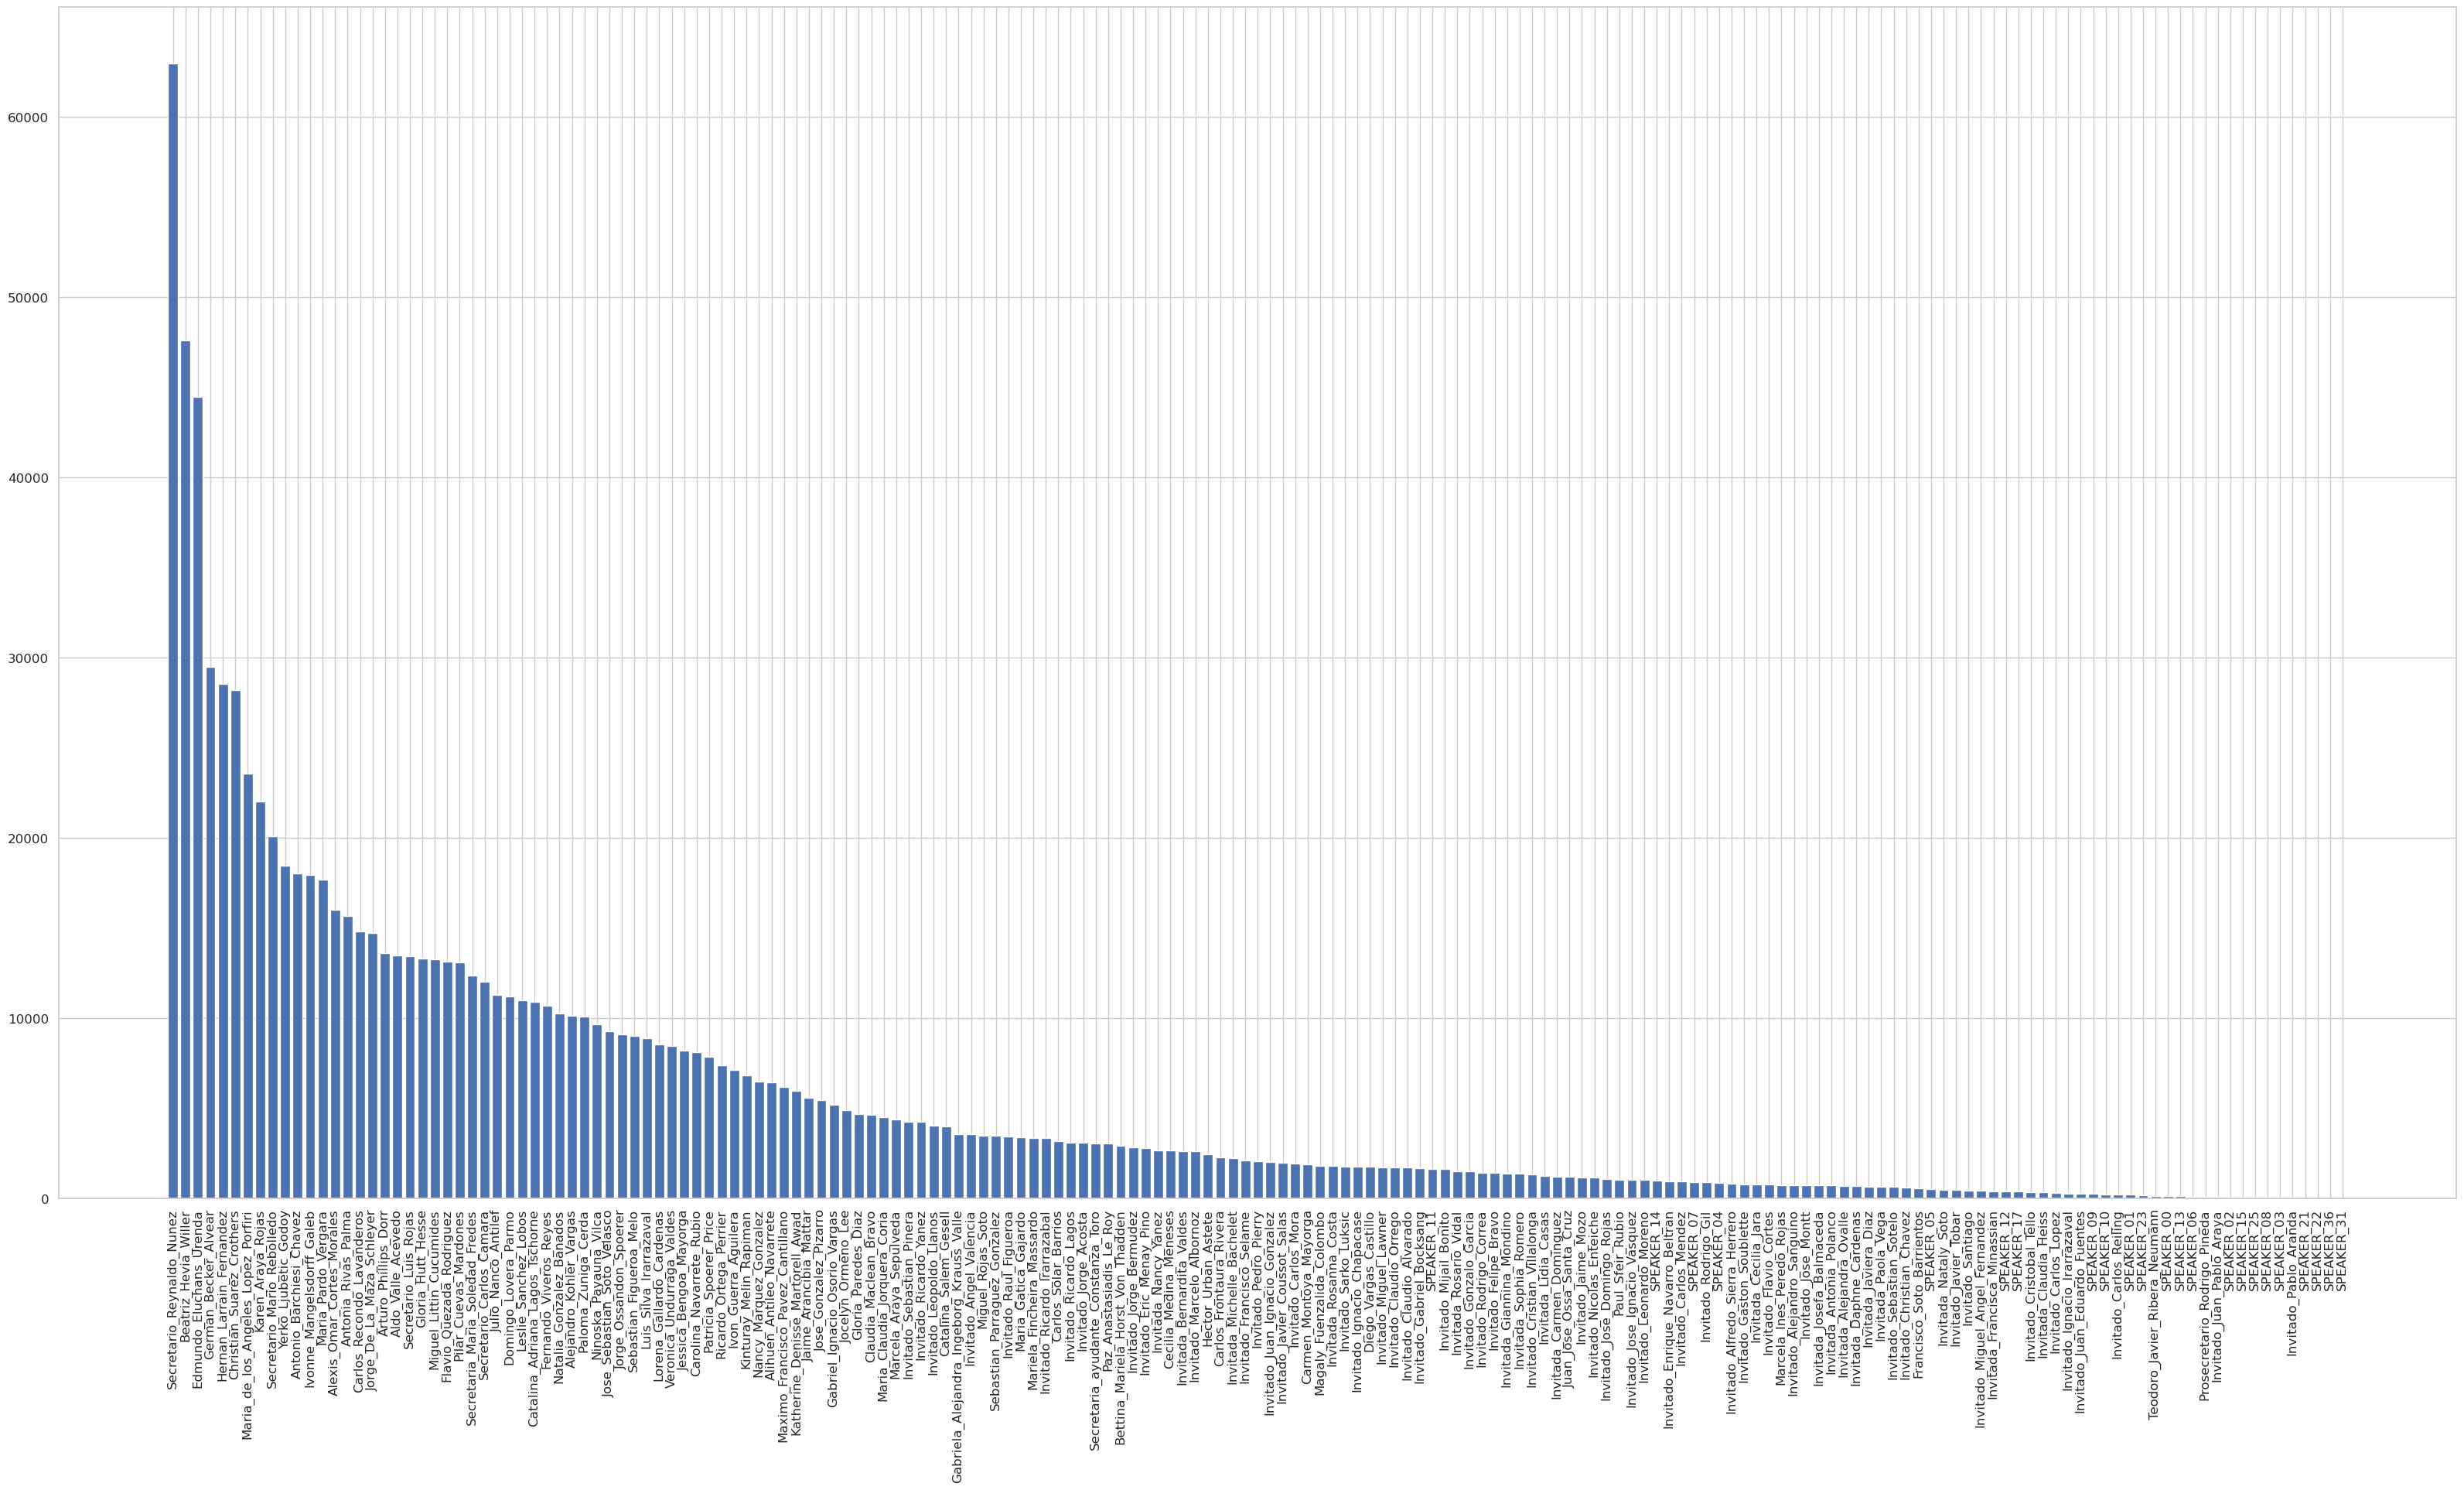

In [ ]:
import json
import seaborn as sns
import matplotlib.pyplot as plt

json_path = '/home/edu/ds-hear-module/speakers.json'

with open(json_path, 'r') as json_file:
    speakers = json.load(json_file)

x = list(speakers.keys())
y = [sum(speakers[speaker].values()) for speaker in x]

# Pair x and y, sort by y, then unzip
paired = zip(x, y)
sorted_pairs = sorted(paired, key=lambda item: item[1], reverse=True)

# Unzip the pairs
x_sorted, y_sorted = zip(*sorted_pairs)

# Convert the tuples back to lists, if needed
x_sorted = list(x_sorted)
y_sorted = list(y_sorted)

sns.set(style="whitegrid")
plt.figure(figsize=(40, 20))
plt.bar(x_sorted, y_sorted)
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)

In [ ]:
import pandas as pd

pd.set_option('display.max_rows', 180)
df = pd.DataFrame({'speaker': x_sorted, 'count': y_sorted})

# Removing guests and unlabeled speakers
# mask = df['speaker'].str.contains('vitad', case=False, na=False) | df['speaker'].str.contains('SPEAKER', case=False, na=False)  
mask = df['speaker'].str.contains('SPEAKER', case=False, na=False)  
# Use the mask to filter out the rows
df_filtered = df[~mask]

df_filtered.reset_index(inplace=True, drop=True)

df_filtered

,speaker,count
0,Secretario_Reynaldo_Nunez,62943
1,Beatriz_Hevia_Willer,47591
2,Edmundo_Eluchans_Urenda,44471
3,German_Becker_Alvear,29469
4,Hernan_Larrain_Fernandez,28534
5,Christian_Suarez_Crothers,28194
6,Maria_de_los_Angeles_Lopez_Porfiri,23580
7,Karen_Araya_Rojas,22010
8,Secretario_Mario_Rebolledo,20101
9,Yerko_Ljubetic_Godoy,18463


In [ ]:
import os

audio_dir = '/home/edu/data/raw_audios'
label_dir = '/home/edu/data/labels/backup-cnn/speaker/consejo_constitucional_clean'

audios = os.listdir(audio_dir)
labels = os.listdir(label_dir)

audios = [audio.split('.')[0] for audio in audios]
labels = [label.split('.')[0] for label in labels]

audios.sort()
labels.sort()

print(f'Number of audios: {len(audios)}')
print(f'Number of labels: {len(labels)}')


Number of audios: 68
Number of labels: 68


In [ ]:
# Convert lists to sets
set_audios = set(audios)
set_labels = set(labels)

# Find elements in a but not in b
only_in_audios = set_audios - set_labels

# Find elements in b but not in a
only_in_labels = set_labels - set_audios

# Convert the sets back to lists (if needed)
only_in_audios = list(only_in_audios)
only_in_labels = list(only_in_labels)

only_in_audios.sort()
only_in_labels.sort()

print("Only in audios:")
for item in only_in_audios:
    print(item)

print("Only in labels:")
for item in only_in_labels:
    print(item)
    

Only in audios:
Only in labels:


Secreatrio_Mario_Rebolledo, Secretario_Mario_Rebolledo
